In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# oof_fc, oof_sd, oof_pso, oof_dso

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')

In [4]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [5]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [6]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [7]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [8]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [9]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 408.70 Mb (54.0% reduction)
Mem. usage decreased to 195.94 Mb (48.8% reduction)


In [10]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
    df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
    df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
    df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
    df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
    df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
    df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
    df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
    df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
    df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
    df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
    df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
    df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
    df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
    df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
    df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min', 'skew', 'median']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [11]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 14064.57 Mb (-36.0% reduction)


In [12]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 7535.15 Mb (-36.2% reduction)


In [13]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [14]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [15]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [16]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [17]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type']

In [18]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [19]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [20]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [21]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [22]:
X = train[good_columns].copy()
y = train['scalar_coupling_constant']
y_fc = train['fc']
y_sd = train['sd']
y_pso = train['pso']
y_dso = train['dso']
X_test = test[good_columns].copy()

In [23]:
del train, test

In [24]:
import gc
gc.collect()

528

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [26]:
# params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }
# result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000)

Fold 1 started at Sun Jun  9 18:13:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.12447	valid_1's l1: 1.16845
[1000]	training's l1: 0.993481	valid_1's l1: 1.06722
[1500]	training's l1: 0.916564	valid_1's l1: 1.01727
[2000]	training's l1: 0.858299	valid_1's l1: 0.982251
[2500]	training's l1: 0.811047	valid_1's l1: 0.955954
[3000]	training's l1: 0.772195	valid_1's l1: 0.936167
[3500]	training's l1: 0.738315	valid_1's l1: 0.919663
[4000]	training's l1: 0.708676	valid_1's l1: 0.906476
[4500]	training's l1: 0.681903	valid_1's l1: 0.895034
[5000]	training's l1: 0.657169	valid_1's l1: 0.884963
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.657169	valid_1's l1: 0.884963
Fold 2 started at Sun Jun  9 18:30:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.124	valid_1's l1: 1.16819
[1000]	training's l1: 0.995327	valid_1's l1: 1.07055
[1500]	training's l1: 0.917726	valid_1's l1: 1.01

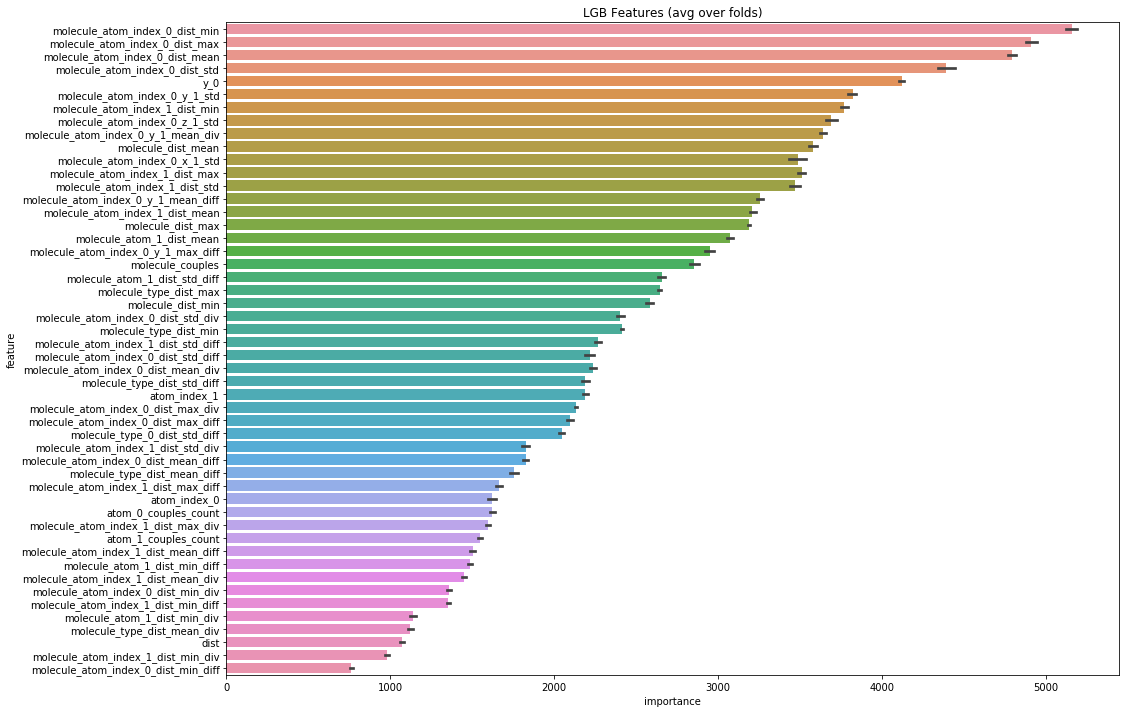

In [27]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb1 = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [29]:
oof_fc = result_dict_lgb1['oof']
test_oof_fc = result_dict_lgb1['prediction']

Fold 1 started at Sun Jun  9 22:51:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0130753	valid_1's l1: 0.0135646
[1000]	training's l1: 0.0115997	valid_1's l1: 0.0124229
[1500]	training's l1: 0.0107118	valid_1's l1: 0.0118138
[2000]	training's l1: 0.0100637	valid_1's l1: 0.0114117
[2500]	training's l1: 0.0095488	valid_1's l1: 0.0111254
[3000]	training's l1: 0.00911074	valid_1's l1: 0.0108921
[3500]	training's l1: 0.0087274	valid_1's l1: 0.0106979
[4000]	training's l1: 0.00838949	valid_1's l1: 0.0105378
[4500]	training's l1: 0.0080912	valid_1's l1: 0.0104072
[5000]	training's l1: 0.00781852	valid_1's l1: 0.0102943
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00781852	valid_1's l1: 0.0102943
Fold 2 started at Sun Jun  9 23:09:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.013083	valid_1's l1: 0.0135611
[1000]	training's l1: 0.0116178	valid_1's l1: 0.0124277
[1500]	trai

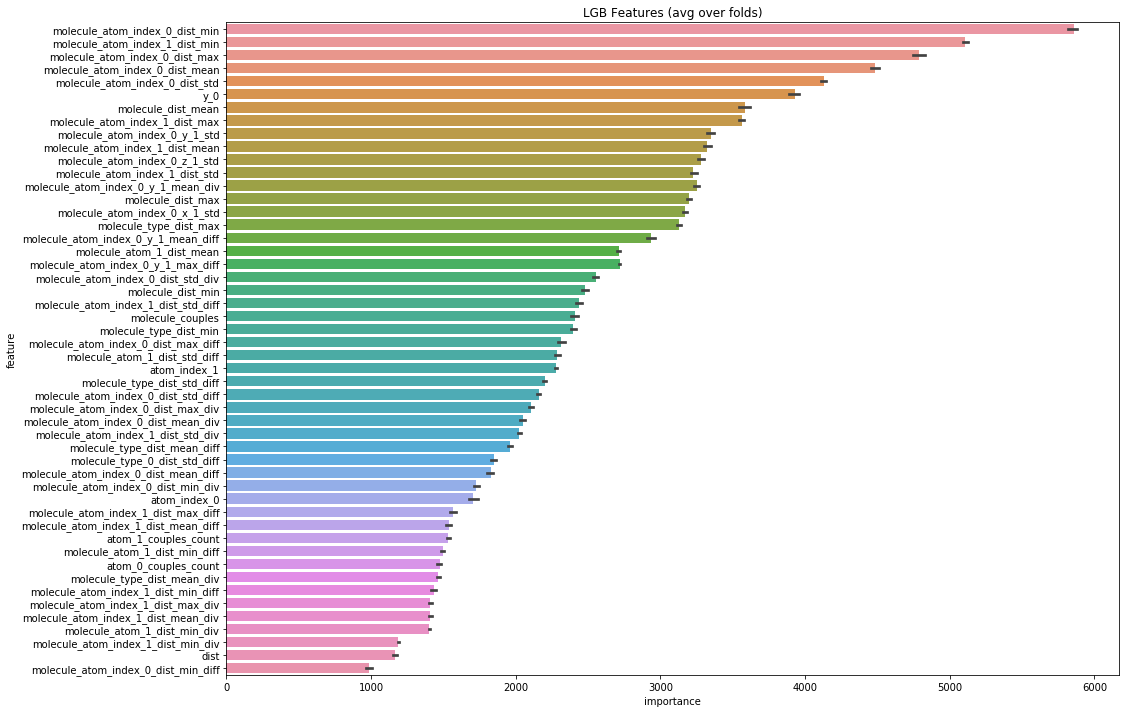

In [30]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y_sd, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [31]:
oof_sd = result_dict_lgb2['oof']
test_oof_sd = result_dict_lgb2['prediction']

Fold 1 started at Mon Jun 10 00:22:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0555255	valid_1's l1: 0.0576224
[1000]	training's l1: 0.048716	valid_1's l1: 0.0522193
[1500]	training's l1: 0.0447493	valid_1's l1: 0.0494739
[2000]	training's l1: 0.0418011	valid_1's l1: 0.0475711
[2500]	training's l1: 0.0394812	valid_1's l1: 0.0462044
[3000]	training's l1: 0.0375223	valid_1's l1: 0.045106
[3500]	training's l1: 0.0358734	valid_1's l1: 0.0442586
[4000]	training's l1: 0.0344139	valid_1's l1: 0.0435501
[4500]	training's l1: 0.0331253	valid_1's l1: 0.04295
[5000]	training's l1: 0.031929	valid_1's l1: 0.0424107
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.031929	valid_1's l1: 0.0424107
Fold 2 started at Mon Jun 10 00:40:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0554436	valid_1's l1: 0.0574413
[1000]	training's l1: 0.0489818	valid_1's l1: 0.0524107
[1500]	training's l1

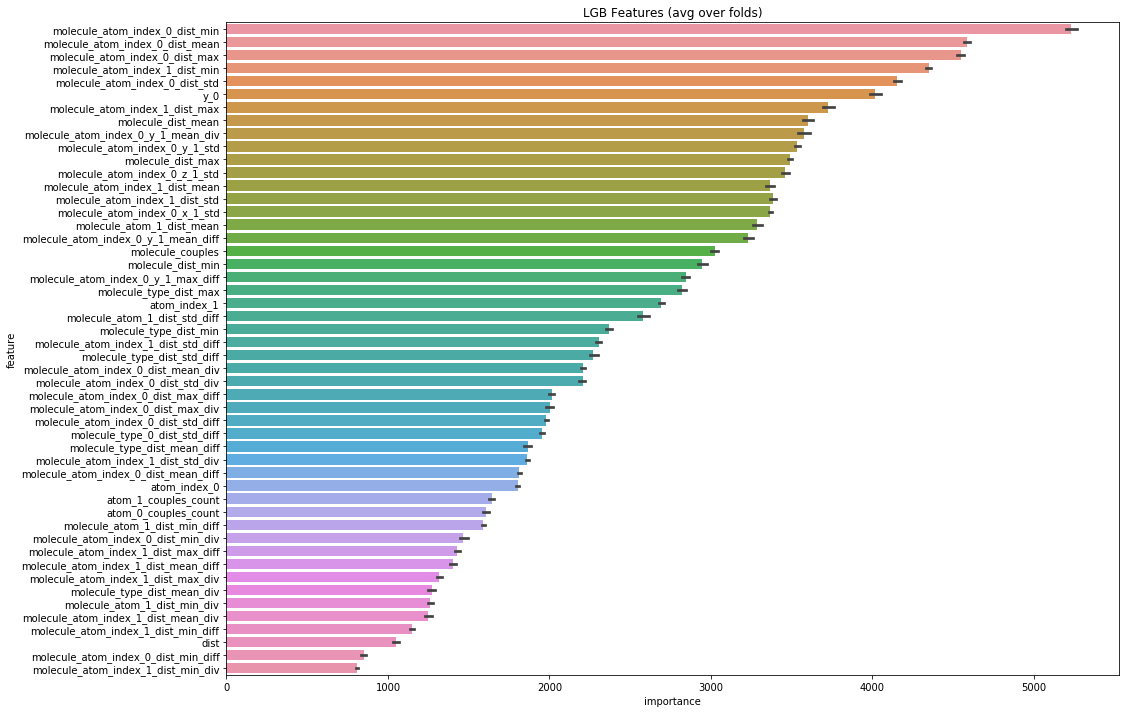

In [32]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb3 = train_model_regression(X=X, X_test=X_test, y=y_pso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [33]:
oof_pso = result_dict_lgb3['oof']
test_oof_pso = result_dict_lgb3['prediction']

Fold 1 started at Mon Jun 10 01:52:25 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0461167	valid_1's l1: 0.0482164
[1000]	training's l1: 0.0403015	valid_1's l1: 0.043686
[1500]	training's l1: 0.0368968	valid_1's l1: 0.0413155
[2000]	training's l1: 0.0344385	valid_1's l1: 0.0397806
[2500]	training's l1: 0.0324859	valid_1's l1: 0.0386679
[3000]	training's l1: 0.0308354	valid_1's l1: 0.0377804
[3500]	training's l1: 0.0294347	valid_1's l1: 0.0370719
[4000]	training's l1: 0.0281889	valid_1's l1: 0.0364694
[4500]	training's l1: 0.0270705	valid_1's l1: 0.0359524
[5000]	training's l1: 0.0260714	valid_1's l1: 0.035517
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0260714	valid_1's l1: 0.035517
Fold 2 started at Mon Jun 10 02:10:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0460398	valid_1's l1: 0.0480118
[1000]	training's l1: 0.040317	valid_1's l1: 0.0435492
[1500]	training's 

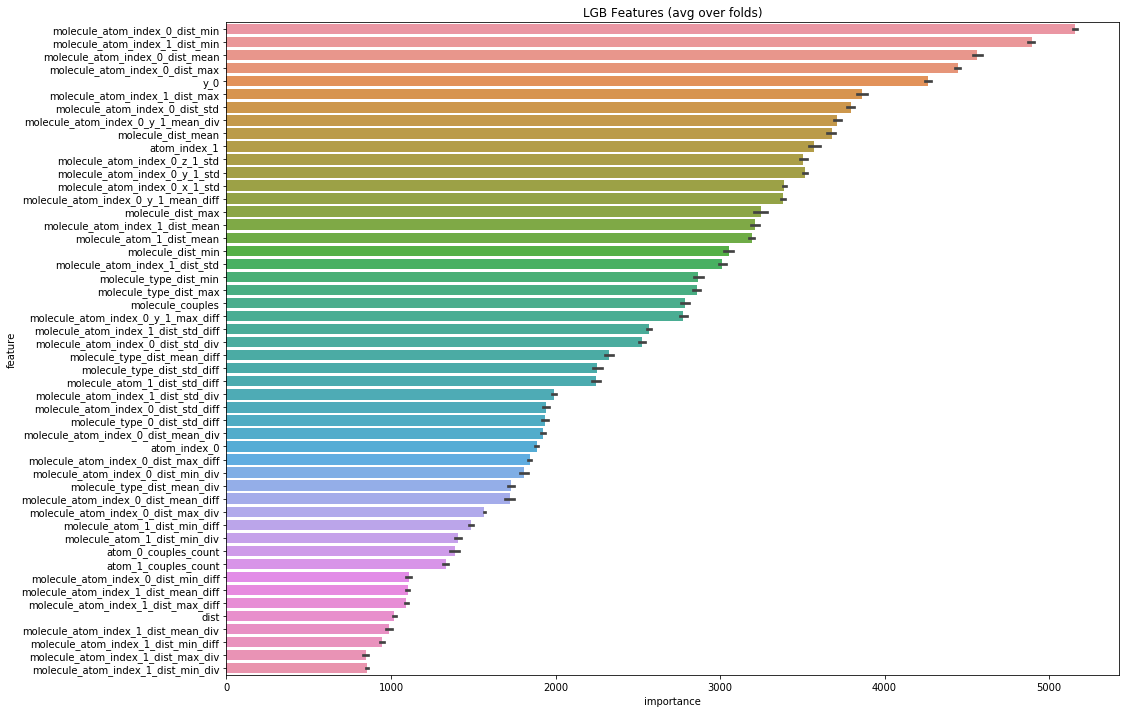

In [34]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb4 = train_model_regression(X=X, X_test=X_test, y=y_dso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [35]:
oof_dso = result_dict_lgb4['oof']
test_oof_dso = result_dict_lgb4['prediction']

In [36]:
X['oof_fc'] = oof_fc
X_test['oof_fc'] = test_oof_fc

X['oof_sd'] = oof_sd
X_test['oof_sd'] = test_oof_sd

X['oof_pso'] = oof_pso
X_test['oof_pso'] = test_oof_pso

X['oof_dso'] = oof_dso
X_test['oof_dso'] = test_oof_dso

X['oof_scalar_cc'] = X['oof_fc'] + X['oof_sd'] + X['oof_pso'] + X['oof_dso']
X_test['oof_scalar_cc'] = X_test['oof_fc'] + X_test['oof_sd'] + X_test['oof_pso'] + X_test['oof_dso']

In [37]:
del result_dict_lgb1, result_dict_lgb2, result_dict_lgb3, result_dict_lgb4
gc.collect()

43510

Fold 1 started at Mon Jun 10 03:24:38 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.782181	valid_1's l1: 0.818281
[1000]	training's l1: 0.735057	valid_1's l1: 0.798712
[1500]	training's l1: 0.697481	valid_1's l1: 0.784567
[2000]	training's l1: 0.666973	valid_1's l1: 0.774667
[2500]	training's l1: 0.6397	valid_1's l1: 0.766183
[3000]	training's l1: 0.615621	valid_1's l1: 0.758834
[3500]	training's l1: 0.593304	valid_1's l1: 0.75265
[4000]	training's l1: 0.573163	valid_1's l1: 0.747003
[4500]	training's l1: 0.554215	valid_1's l1: 0.742035
[5000]	training's l1: 0.536385	valid_1's l1: 0.737297
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.536385	valid_1's l1: 0.737297
Fold 2 started at Mon Jun 10 03:42:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.780847	valid_1's l1: 0.818908
[1000]	training's l1: 0.7335	valid_1's l1: 0.798966
[1500]	training's l1: 0.696309	valid_1's l1: 

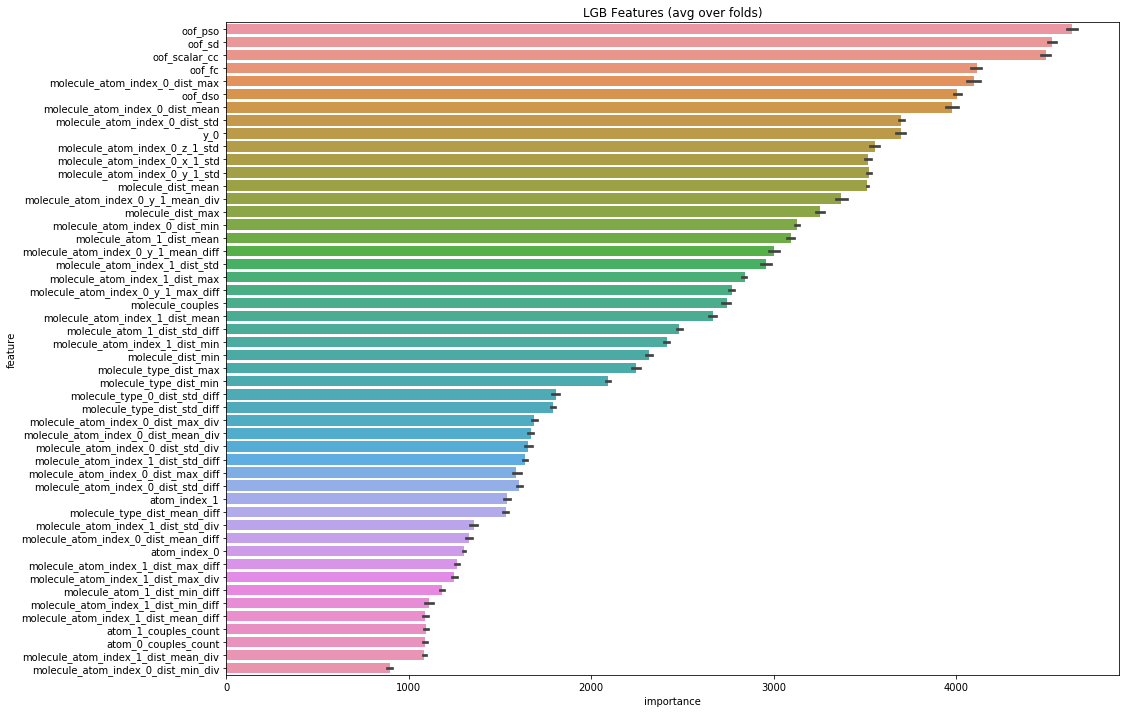

In [38]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [39]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub5.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Mon Jun 10 04:53:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.29162	valid_1's l1: 1.52881
[1000]	training's l1: 1.08517	valid_1's l1: 1.49044
[1500]	training's l1: 0.927949	valid_1's l1: 1.46551
[2000]	training's l1: 0.802157	valid_1's l1: 1.4484
[2500]	training's l1: 0.700119	valid_1's l1: 1.43543
[3000]	training's l1: 0.614101	valid_1's l1: 1.42552
[3500]	training's l1: 0.541962	valid_1's l1: 1.41911
[4000]	training's l1: 0.481913	valid_1's l1: 1.41267
[4500]	training's l1: 0.429545	valid_1's l1: 1.40846
[5000]	training's l1: 0.384254	valid_1's l1: 1.40464
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.384254	valid_1's l1: 1.40464
Fold 2 started at Mon Jun 10 04:57:22 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.28801	valid_1's l1: 1.52843
[1000]	training's l1: 1.08017	valid_1's l1: 1.49109
[1500]	training's l1: 0.92172	valid_1's

Fold 2 started at Mon Jun 10 05:26:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.339907	valid_1's l1: 0.825916
[1000]	training's l1: 0.161004	valid_1's l1: 0.807342
[1500]	training's l1: 0.081589	valid_1's l1: 0.801387
[2000]	training's l1: 0.0417202	valid_1's l1: 0.79928
[2500]	training's l1: 0.0210596	valid_1's l1: 0.798333
[3000]	training's l1: 0.0103991	valid_1's l1: 0.797848
[3500]	training's l1: 0.00541867	valid_1's l1: 0.797675
[4000]	training's l1: 0.00335808	valid_1's l1: 0.797605
[4500]	training's l1: 0.002504	valid_1's l1: 0.797572
[5000]	training's l1: 0.00209602	valid_1's l1: 0.797555
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00209602	valid_1's l1: 0.797555
Fold 3 started at Mon Jun 10 05:26:48 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.338501	valid_1's l1: 0.807173
[1000]	training's l1: 0.159549	valid_1's l1: 0.788534
[1500]	training's l1: 0.079164

Fold 3 started at Mon Jun 10 05:45:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.60953	valid_1's l1: 0.694214
[1000]	training's l1: 0.518626	valid_1's l1: 0.662288
[1500]	training's l1: 0.452951	valid_1's l1: 0.643396
[2000]	training's l1: 0.401301	valid_1's l1: 0.631343
[2500]	training's l1: 0.358576	valid_1's l1: 0.621937
[3000]	training's l1: 0.323167	valid_1's l1: 0.614918
[3500]	training's l1: 0.292685	valid_1's l1: 0.609956
[4000]	training's l1: 0.266278	valid_1's l1: 0.605351
[4500]	training's l1: 0.24311	valid_1's l1: 0.601936
[5000]	training's l1: 0.222688	valid_1's l1: 0.599185
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.222688	valid_1's l1: 0.599185
Fold 4 started at Mon Jun 10 05:51:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.612842	valid_1's l1: 0.693462
[1000]	training's l1: 0.523165	valid_1's l1: 0.661686
[1500]	training's l1: 0.45654	valid_1's l1

Fold 4 started at Mon Jun 10 06:41:03 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.639009	valid_1's l1: 0.701413
[1000]	training's l1: 0.566691	valid_1's l1: 0.675706
[1500]	training's l1: 0.51069	valid_1's l1: 0.658554
[2000]	training's l1: 0.465152	valid_1's l1: 0.647061
[2500]	training's l1: 0.426388	valid_1's l1: 0.638222
[3000]	training's l1: 0.392089	valid_1's l1: 0.630603
[3500]	training's l1: 0.362159	valid_1's l1: 0.624457
[4000]	training's l1: 0.335774	valid_1's l1: 0.619946
[4500]	training's l1: 0.312101	valid_1's l1: 0.615914
[5000]	training's l1: 0.290793	valid_1's l1: 0.612593
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.290793	valid_1's l1: 0.612593
Fold 5 started at Mon Jun 10 06:48:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.638498	valid_1's l1: 0.701415
[1000]	training's l1: 0.566796	valid_1's l1: 0.675944
[1500]	training's l1: 0.511198	valid_1's 

id  scalar_coupling_constant
0  4658147         9.523102729866689
1  4658148       190.391316071411836
2  4658149         5.851118175907503
3  4658150       187.256516553895523
4  4658151         4.533839821324579

In [40]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub5.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:55<00:00, 1.20MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 1.23 s, sys: 317 ms, total: 1.54 s
Wall time: 58.1 s


In [41]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub5.csv   2019-06-10 01:33:16  None         pending   None         None          
sub4a.csv  2019-06-09 09:26:24  None         complete  -0.830       None          
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1.csv   2019-06-04 16:51:51  None         complete  0.299        None          


In [41]:
scalar_coupling_contributions.head()

molecule_name  atom_index_0  atom_index_1  type                  fc  \
0  dsgdb9nsd_000001             1             0  1JHC  83.022400000000005   
1  dsgdb9nsd_000001             1             2  2JHH -11.034700000000001   
2  dsgdb9nsd_000001             1             3  2JHH -11.032500000000001   
3  dsgdb9nsd_000001             1             4  2JHH -11.031900000000000   
4  dsgdb9nsd_000001             2             0  1JHC  83.022199999999998   

         sd      pso       dso  
0  0.254579  1.25862  0.272010  
1  0.352978  2.85839 -3.433600  
2  0.352944  2.85852 -3.433870  
3  0.352934  2.85855 -3.433930  
4  0.254585  1.25861  0.272013

In [3]:
0.254579	 +  1.25862 + 0.272010 + 83.022400000000005

84.807609